# Extended Kalman Filter

In [1]:
#Importing All Libraries

import pickle  #For Data Handling
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion #For Quaternions and Euler angles

In [2]:
#Load the Data

with open('data/pt1_data.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
# gt: Data object containing ground truth, with the following fields:
# imu_a.data : IMU accelerations in Vehicle Frame
# imu_w.data : IMU angular velocities in Vehicle Frame (Used for quaternion calculations)
# gnss.data : GNSS data
# lidar.data : LIDAR data
# imu_a.t, imu_w.t, gnss.t, lidar.t : Respective timestamps
   
#These are the StampedData objects
gt = data['gt']
imu_a = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

#These are the total number of observations obtained from each sensor in the total timespan of trajectory
IMU_time = 8734
LIDAR_time = 415
GNSS_time = 45

#Use the following actual data and timestamps, obtained from the StampedData object
imu_a.data = imu_a.data[0:IMU_time, :]
imu_a.t = imu_a.t[0:IMU_time]
imu_w.data = imu_w.data[0:IMU_time, :]
imu_w.t = imu_w.t[0:IMU_time]
gnss.data = gnss.data[0:GNSS_time, :]
gnss.t = gnss.t[0:GNSS_time]
lidar.data = lidar.data[0:LIDAR_time, :]
lidar.t = lidar.t[0:LIDAR_time]



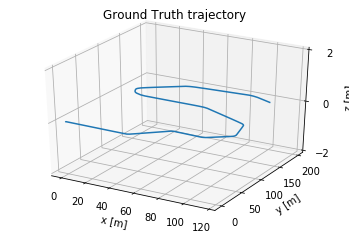

In [4]:
#Run this cell to observe the ground truth tajectory

gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-2, 2)
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, 0, 2])
plt.show()

In [5]:
# Transform the LIDAR data from the LIDAR frame to the vehicle (IMU) frame.

#Rotation Matrix
C_li = np.array([
     [ 0.9975 , -0.04742,  0.05235],
     [ 0.04992,  0.99763, -0.04742],
     [-0.04998,  0.04992,  0.9975 ]
])

#Translation Matrix
t_i_li = np.array([0.5, 0.1, 0.5])

lidar.data = (C_li @ lidar.data.T).T + t_i_li

In [6]:
# 1) Define variances for different sensors
# This will be used to construct the Covariance matrices

var_imu_a = 0.01
var_imu_w = 0.01
var_gnss  = 0.01
var_lidar = 0.01


In [7]:
#The Jacobians 'L' and 'H' and gravity 'g'

g = np.array([0, 0, -9.81])  # gravity


L = np.zeros([9, 6])
#9x6 beacuse we are mapping 9 values to the motion state equation from 6 values of motion
#6 values of motion (form sensors 3 velocities 3 acceleration) to 9 values of state( 3 pos 3 vel 3 acc)
L[3:, :] = np.eye(6)  # motion model noise jacobian


H = np.zeros([3, 9])
#3x9 beacause H= dh/dx_k here h is the meauremnt state vector of size 3 and xis our motion state vector of size 9
#H maps the predicted motion state to the expected measurement state
H[:, :3] = np.eye(3)  # measurement model jacobian

#L=np.random.rand(9,6)/1000
#H=np.random.rand(3,9)/1000


In [8]:
#There are total 10 states for a Self Driving Car
# 3 for Positions in each direction (px, py and pz)
# 3 for Velocities in each direction (vx, vy and vz)
# 4 for Quaternions 

#Create an array of zeros for each state
p_est = np.zeros([imu_a.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_a.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_a.data.shape[0], 4])  # orientation estimates as quaternions

p_cov = np.zeros([imu_a.data.shape[0], 9, 9])  # covariance matrices at each timestep

# Set initial values.
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.zeros(9)  # covariance of estimate

In [9]:
# Create a function to evaluate Measurement update for LIDAR and/or GNSS data

def measurement_update(sensor_var, p_cov_check, z_k, p_check, v_check, q_check):
    # 1) Transform Sensor Variance into Matrix form (Covariance matrix)
    R_cov=np.eye(3)*sensor_var
    
    # 2) Compute Kalman Gain
    S=H.dot((p_cov_check).dot(H.T)) + R_cov
    K=p_cov_check.dot((H.T).dot(np.linalg.inv(S)))
    
    # 3) Compute innovation and multiply kalman gain
    I = z_k-p_check
    X=K.dot(I)
    
    # 4) Correct predicted state
    p_hat = p_check + X[0:3]
    v_hat = v_check + X[3:6]
    
    
    # Corrected state for Quaternions
    q_hat = Quaternion(euler=X[6:]).quat_mult_left(q_check)

    # 5) Compute corrected covariance
    p_cov_hat=(np.eye(9)-K.dot(H)).dot(p_cov_check)
   
    
    return p_hat, v_hat,q_hat, p_cov_hat

In [10]:
# Motion Model loop to predict using IMU values



for k in range(1, imu_a.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
            
    # 1) Calculate "delta_t"
    delta_t=imu_a.t[k]-imu_a.t[k-1]
    
    # 2) Update state with IMU inputs ("p_k, v_k")    
    #C_ns is Euler estimation for Quaternions
    # In position update, use matrix multiplication of (C_ns and imu_a.data[number]) to linearize the model
    # Instead of just using imu_a.data[number] (Use this in velocity)
    C_ns = Quaternion(*q_est[k-1]).to_mat()
    p_k= p_est[k-1]+v_est[k-1]*delta_t+0.5*(C_ns.dot((imu_a.data[k-1])+g))*(delta_t**2)
    v_k= v_est[k-1]+(C_ns.dot((imu_a.data[k-1])+g))*delta_t
    

    # Quaternion States update
    q_k = Quaternion(axis_angle=imu_w.data[k-1]*delta_t).quat_mult_right(q_est[k-1])    

    # Linearize the motion model and compute Jacobians
    Fk = np.eye(9)
    Fk[0:3, 3:6] = np.eye(3)*delta_t
    Fk[3:6, 3:6] = np.eye(3)
    Fk[3:6, 6:9] = -(C_ns@skew_symmetric(imu_a.data[k-1].reshape((3,1))))*delta_t
    
    # 3) Propagate uncertainty 
    Q = np.eye(6)
    Q[0:3, 0:3] = var_imu_a * Q[0:3, 0:3]
    Q[3:6, 3:6] = var_imu_w * Q[3:6, 3:6]
    Q = np.dot(Q,Q.T)*(delta_t ** 2) #Integration acceleration to obstain Position0
   
    # 4) Calculate Covariance Matrix (A diagonal matrix consisting of multiple variances)
    p_cov_check=Fk.dot((p_cov[k - 1]).dot(Fk.T)) + L.dot((Q).dot(L.T)) 
    
    # 5) Check if GNSS and LIDAR measurements are avaiable
    for i in range(len(gnss.t)):
        if abs(gnss.t[i] - imu_a.t[k]) <=0.26:
            p_k, v_k,q_k, p_cov_check = measurement_update(var_gnss, p_cov_check, gnss.data[i], p_k, v_k, q_k)
    for i in range(len(lidar.t)):
        if abs(lidar.t[i] - imu_a.t[k]) ==0:
            p_k, v_k,q_k, p_cov_check = measurement_update(var_lidar, p_cov_check, lidar.data[i], p_k, v_k, q_k)
    
    
    #updating 
    p_est[k,:] = p_k
    v_est[k,:] = v_k
    q_est[k,:] = q_k
    p_cov[k,:,:] = p_cov_check

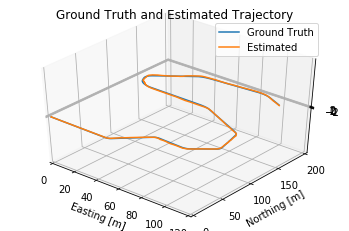

The Mean Squared Error is :3.1523085368545334 


In [11]:
# Visualize your trajectory w.r.t. the ground truth trajectory and calculate the mean squared error

est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 120)
ax.set_ylim(0, 200)
ax.set_zlim(-100, 100)
ax.set_xticks([0, 20, 40, 60, 80, 100, 120])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=40, azim=-50)
plt.show()

MSE = np.sum(np.square(np.subtract(gt.p, p_est)), axis=None)/IMU_time
print("The Mean Squared Error is :{0} ".format(MSE))